In [1]:
import cv2                 # working with, mainly resizing, images
import numpy as np         # dealing with arrays
import os                  # dealing with directories
from random import shuffle # mixing up or currently ordered data that might lead our network astray in training.
from tqdm import tqdm      # a nice pretty percentage bar for tasks.
import pandas as pd
TRAIN_DIR = 'C:/Users/Dell/Desktop/ML/trial_project/train_images'
TEST_DIR = 'C:/Users/Dell/Desktop/ML/trial_project/test_images'
IMG_SIZE = 250
LR = 1e-3
MODEL_NAME = 'diabeticretinopathy-{}-{}.model'.format(LR, '5conv-basic')

In [2]:
def label_img(word_label):
    if word_label == 0: return [1,0,0,0,0]
    elif word_label == 1: return [0,1,0,0,0]
    elif word_label == 2: return [0,0,1,0,0]
    elif word_label == 3: return [0,0,0,1,0]
    elif word_label == 4: return [0,0,0,0,1]

In [3]:
def create_train_data():
    training_data = []
    train_df = pd.read_csv('train.csv')
    for img in tqdm(os.listdir(TRAIN_DIR)):
        for i in range(len(train_df)):
            img1 = img.split('.')[0]
            if  img1 == train_df['id_code'][i]:
                label = label_img(train_df['diagnosis'][i])
        path = os.path.join(TRAIN_DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        training_data.append([np.array(img),np.array(label)])
    shuffle(training_data)
    np.save('train_data.npy', training_data)
    return training_data

In [4]:
def process_test_data():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR,img)
        img_num = img.split('.')[0]
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        testing_data.append([np.array(img), img_num])
        
    shuffle(testing_data)
    np.save('test_data.npy', testing_data)
    return testing_data

In [5]:
#train_data = create_train_data()
#If you have already created the dataset:
train_data = np.load('train_data.npy')

In [5]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression
import tensorflow as tf
tf.reset_default_graph()

convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 3], name='input')

convnet = conv_2d(convnet, 32, 3, activation='relu')
convnet = max_pool_2d(convnet, 3)

convnet = conv_2d(convnet, 64, 3, activation='relu')
convnet = max_pool_2d(convnet, 3)

convnet = conv_2d(convnet, 128, 3, activation='relu')
convnet = max_pool_2d(convnet, 3)

convnet = conv_2d(convnet, 32, 3, activation='relu')
convnet = max_pool_2d(convnet, 3)

convnet = conv_2d(convnet, 64, 3, activation='relu')
convnet = max_pool_2d(convnet, 3)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.5)

convnet = fully_connected(convnet, 5, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')

curses is not supported on this machine (please install/reinstall curses for an optimal experience)


W0414 15:59:47.451944 11168 deprecation_wrapper.py:119] From C:\Users\Dell\Anaconda3\lib\site-packages\tflearn\helpers\summarizer.py:9: The name tf.summary.merge is deprecated. Please use tf.compat.v1.summary.merge instead.

W0414 15:59:47.460230 11168 deprecation_wrapper.py:119] From C:\Users\Dell\Anaconda3\lib\site-packages\tflearn\helpers\trainer.py:25: The name tf.summary.FileWriter is deprecated. Please use tf.compat.v1.summary.FileWriter instead.

W0414 15:59:47.657650 11168 deprecation_wrapper.py:119] From C:\Users\Dell\Anaconda3\lib\site-packages\tflearn\collections.py:13: The name tf.GraphKeys is deprecated. Please use tf.compat.v1.GraphKeys instead.

W0414 15:59:47.826174 11168 deprecation_wrapper.py:119] From C:\Users\Dell\Anaconda3\lib\site-packages\tflearn\config.py:123: The name tf.get_collection is deprecated. Please use tf.compat.v1.get_collection instead.

W0414 15:59:48.676043 11168 deprecation_wrapper.py:119] From C:\Users\Dell\Anaconda3\lib\site-packages\tflearn\con

In [6]:
if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model loaded!')

W0414 16:00:16.032857 11168 deprecation.py:323] From C:\Users\Dell\Anaconda3\lib\site-packages\tensorflow\python\training\saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


model loaded!


In [7]:
train = train_data[:-500]
test = train_data[-500:]

NameError: name 'train_data' is not defined

In [9]:
X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,3)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,3)
test_y = [i[1] for i in test]


In [10]:
model.fit({'input': X}, {'targets': Y}, n_epoch=3, validation_set=({'input': test_x}, {'targets': test_y}),
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 149  | total loss: 0.75732 | time: 135.841s
| Adam | epoch: 003 | loss: 0.75732 - acc: 0.7210 -- iter: 3136/3162
Training Step: 150  | total loss: 0.74376 | time: 144.559s
| Adam | epoch: 003 | loss: 0.74376 - acc: 0.7254 | val_loss: 0.74536 - val_acc: 0.7040 -- iter: 3162/3162
--


In [11]:
model.save(MODEL_NAME)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.05it/s]


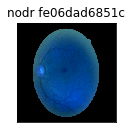

In [16]:
import matplotlib.pyplot as plt
test_data = process_test_data()
#test_data = np.load(test_data.npy)

fig = plt.figure()
for num, data in enumerate(test_data[:]):
    img_num = data[1]
    img_data = data[0]
    y = fig.add_subplot(2,2,num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE,IMG_SIZE,3)
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 0: str_label = 'nodr'
    elif np.argmax(model_out) == 1: str_label = 'mild'
    elif np.argmax(model_out) == 2: str_label = 'moderate'
    elif np.argmax(model_out) == 3: str_label = 'severe'
    elif np.argmax(model_out) == 4: str_label = 'proliferative'
    
    y.imshow(orig,cmap = 'gray')
    
    plt.title(str_label+' '+img_num)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()

In [ ]:
#tensorboard --logdir=foo:C:\Users\Dell\Desktop\ML\trial project\log
#tensorboard --logdir=data/ --host localhost --port 8088
#tensorboard --logdir=foo:C:\Users\Dell\Desktop\ML\Test_dr\log --host localhost --port 8088

In [ ]:
src = model.evaluate(test_x,test_y,batch_size=10)

Exception in thread Thread-7:
Traceback (most recent call last):
  File "C:\Users\Dell\Anaconda3\lib\threading.py", line 917, in _bootstrap_inner
    self.run()
  File "C:\Users\Dell\Anaconda3\lib\threading.py", line 865, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\Dell\Anaconda3\lib\site-packages\tflearn\data_flow.py", line 187, in fill_feed_dict_queue
    data = self.retrieve_data(batch_ids)
  File "C:\Users\Dell\Anaconda3\lib\site-packages\tflearn\data_flow.py", line 222, in retrieve_data
    utils.slice_array(self.feed_dict[key], batch_ids)
  File "C:\Users\Dell\Anaconda3\lib\site-packages\tflearn\utils.py", line 180, in slice_array
    return [x[start] for x in X]
  File "C:\Users\Dell\Anaconda3\lib\site-packages\tflearn\utils.py", line 180, in <listcomp>
    return [x[start] for x in X]
IndexError: index 5 is out of bounds for axis 0 with size 5

